# EndotyPy package usage

In [1]:
import EndotypY as edy #type: ignore
import pickle
import networkx as nx


# small use case

In [2]:
path_ppi_mini = '/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/monocyte.tsv'
path_seed_mini = '/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/ibd_risk_genes_mini.txt'

mini = edy.Endotyper()
mini.import_network(path_ppi_mini)
mini.import_seeds(path_seed_mini)

mini

network imported successfully
> Network contains 2866 nodes and 18725 edges

> Loaded 10 seed nodes from file: /Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/ibd_risk_genes_mini.txt
seeds imported successfully


In [3]:
mini.prepare_rwr(r=0.8)

Preparing RWR...
['FCN1', 'PTPN22', 'HNF4A', 'IL2RA', 'EBF1', 'NKX2-3', 'S100A3']
Inverting the matrix takes time, please be patient...
RWR matrix prepared successfully


Running RWR for seed genes: 100%|██████████| 3/3 [00:00<00:00, 21.69it/s]

Testing neighborhood sizes in parallel on 8 cores...



100%|██████████| 6/6 [00:00<00:00, 87992.39it/s]

Optimal neighborhood size found at k=30 with 2 cluster(s).


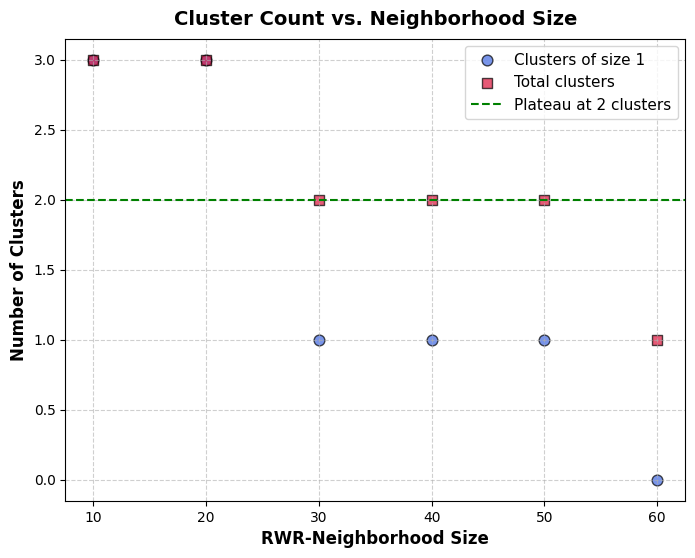

2 Seed clusters identified


{'cluster_seed_1': ['NOD2', 'LRRK2'], 'cluster_seed_2': ['CARD9']}

In [4]:
mini.explore_seed_clusters(scaling=True, k=60)

## larger data

In [5]:
endo = edy.Endotyper()

# read in a graph from a file

#path_ppi = 'ppi.txt'
path_ppi = '/Users/mathilde/Desktop/projects/NetMedRX/test_data/Supplementary_File_1_interactome_edgelist_protein_only.txt'
endo.import_network(path_ppi)

#path_seed = 'ibd_risk_genes_F.txt'
#path_seed = '/Users/mathilde/Desktop/projects/NetMedRX/endotyPy/test_and_dev/ibd_risk_genes_mini.txt'
#read in a seed set from a file
#path_seed = 'example_seeds.txt'
path_seed = '/Users/mathilde/Desktop/projects/NetMedRX/test_data/mono_AIM_AIF_IDs.txt'
endo.import_seeds(path_seed)

endo


network imported successfully
> Network contains 18727 nodes and 476675 edges

> Loaded 186 seed nodes from file: /Users/mathilde/Desktop/projects/NetMedRX/test_data/mono_AIM_AIF_IDs.txt
seeds imported successfully


In [6]:
#prepare RWR
#endo.prepare_rwr(r=0.8)

#from previously saved files
with open('/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/rwr_matrix.pkl', 'rb') as f:
    endo.rwr_matrix = pickle.load(f)
with open('/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/scaling_matrix.pkl', 'rb') as f:
    endo.scaling_matrix = pickle.load(f)
with open('/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/idx_ensembl.pkl', 'rb') as f:
    endo.idx_ensembl = pickle.load(f)

Running RWR for seed genes: 100%|██████████| 186/186 [00:45<00:00,  4.09it/s]

Testing neighborhood sizes in parallel on 8 cores...



100%|██████████| 20/20 [00:00<00:00, 274137.52it/s]


Optimal neighborhood size found at k=80 with 2 cluster(s).


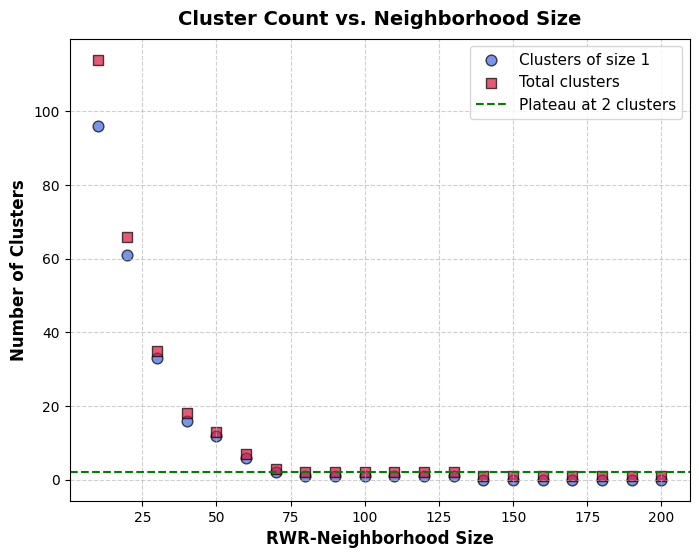

2 Seed clusters identified


{'cluster_seed_1': ['114548',
  '720',
  '732',
  '4860',
  '731',
  '715',
  '8547',
  '57379',
  '55072',
  '7056',
  '5692',
  '3551',
  '9948',
  '7128',
  '100',
  '83737',
  '3845',
  '326',
  '115650',
  '10346',
  '1675',
  '248',
  '3588',
  '3702',
  '55315',
  '54',
  '8546',
  '30817',
  '721',
  '939',
  '4068',
  '718',
  '6023',
  '653361',
  '27040',
  '10878',
  '5994',
  '9652',
  '6786',
  '10616',
  '3559',
  '730',
  '3587',
  '3981',
  '81494',
  '5698',
  '9051',
  '4210',
  '5684',
  '3075',
  '90268',
  '917',
  '735',
  '50619',
  '23495',
  '713',
  '84876',
  '11274',
  '51371',
  '6890',
  '3394',
  '5426',
  '50943',
  '4598',
  '1493',
  '5873',
  '5580',
  '6892',
  '58484',
  '6578',
  '355',
  '1535',
  '7132',
  '6891',
  '5696',
  '10725',
  '5551',
  '10747',
  '79803',
  '1604',
  '717',
  '7048',
  '89781',
  '28755',
  '4790',
  '727',
  '201294',
  '22861',
  '57217',
  '79092',
  '8625',
  '8737',
  '710',
  '1314',
  '959',
  '843',
  '3257',


In [7]:
#explore the seed clusters
endo.explore_seed_clusters(scaling=True, k=200)